In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [42]:
# have a first look at the files
# drop first column because it just has the unit in it
fluxes_fbg = pd.read_csv("EddyCovarianceData/eng/FBG_fluxes_30min_20240401_20240608_eng.csv").drop(0)
fluxes_goew = pd.read_csv("EddyCovarianceData/eng/GoeW_fluxes_30min_20240401_20240608_eng.csv").drop(0)
meteo_fbg = pd.read_csv("MeteorologicalData/eng/FBG_meteo_30min_20240401_20240608_eng.csv").drop(0)
meteo_goew = pd.read_csv("MeteorologicalData/eng/GoeW_meteo_30min_20240401_20240608_eng.csv").drop(0)


Check if data formats are consistent for fbg and goew

In [43]:
print(fluxes_fbg.info())
print(fluxes_goew.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 1 to 3263
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   TIMESTAMP_START  3263 non-null   object
 1   TIMESTAMP_MID    3263 non-null   object
 2   TIMESTAMP_END    3263 non-null   object
 3   H_orig           1820 non-null   object
 4   H_f              3263 non-null   object
 5   LE_orig          1749 non-null   object
 6   LE_f             3263 non-null   object
 7   ET_orig          1749 non-null   object
 8   ET_f             3263 non-null   object
 9   CO2              1701 non-null   object
 10  H2O              1711 non-null   object
 11  NEE_orig         1712 non-null   object
 12  NEE_f            3263 non-null   object
 13  Reco             3263 non-null   object
 14  GPP_f            3263 non-null   object
 15  Ustar            3261 non-null   object
dtypes: object(16)
memory usage: 408.0+ KB
None
<class 'pandas.core.frame.DataFrame

The meteo data seems perfectly consistent.

In [44]:
print(meteo_fbg.info())
print(meteo_goew.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3264 entries, 1 to 3264
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   TIMESTAMP_START                   3264 non-null   object
 1   TIMESTAMP_MID                     3264 non-null   object
 2   TIMESTAMP_END                     3264 non-null   object
 3   incomingShortwaveRadiation_300cm  3264 non-null   object
 4   outgoingShortwaveRadiation_300cm  3264 non-null   object
 5   netRadiation_300cm                3264 non-null   object
 6   incomingPPFD_300cm                3264 non-null   object
 7   outgoingPPFD_300cm                3264 non-null   object
 8   soilHeatFlux                      3264 non-null   object
 9   airPressure                       3264 non-null   object
 10  airTemperature_40cm               3264 non-null   object
 11  airTemperature_200cm              3264 non-null   object
 12  relHumidity_40cm    

The meteo data is a bit different for FBG and Goew. Specifically:
- The Goew FBG data does not contain longwave radiation. This is not a problem since we only need the net radiation.
- For the FBG data, the soil heat flux is missing. Instead, the soil moisture and temperature are measured at different heights which can be used to calculate the soil heat flux.

Overall it seems like all the data that is needed to calculate the Energy Balance Closure is there.

In [45]:
# do some preprocessing on the data
def process_fluxes(df):
    """Convert timestamp columns to date and time
       Adjust dtypes of relevant columns

    Args:
        df (_type_): _description_
    """
    df["DATE_START"] = pd.to_datetime(df["TIMESTAMP_START"].str.split(" ").str[0])
    df["TIME_START"] = df["TIMESTAMP_START"].str.split(" ").str[1]
    df["DATE_MID"] = pd.to_datetime(df["TIMESTAMP_MID"].str.split(" ").str[0])
    df["TIME_MID"] = df["TIMESTAMP_MID"].str.split(" ").str[1]
    df["DATE_END"] = pd.to_datetime(df["TIMESTAMP_END"].str.split(" ").str[0])
    df["TIME_END"] = df["TIMESTAMP_END"].str.split(" ").str[1]
    # df = df.drop(["TIMESTAMP_START", "TIMESTAMP_MID", "TIMESTAMP_END"], axis=1)
    df["H_f"] = df["H_f"].astype(float)
    df["LE_f"] = df["LE_f"].astype(float)
    df["NEE_f"] = df["NEE_f"].astype(float)
    return df


fluxes_fbg = process_fluxes(fluxes_fbg)
fluxes_goew = process_fluxes(fluxes_goew)

# for meteo data do it separately
meteo_fbg["DATE_START"] = pd.to_datetime(meteo_fbg["TIMESTAMP_START"].str.split(" ").str[0])
meteo_fbg["TIME_START"] = meteo_fbg["TIMESTAMP_START"].str.split(" ").str[1]
meteo_fbg["DATE_MID"] = pd.to_datetime(meteo_fbg["TIMESTAMP_MID"].str.split(" ").str[0])
meteo_fbg["TIME_MID"] = meteo_fbg["TIMESTAMP_MID"].str.split(" ").str[1]
meteo_fbg["DATE_END"] = pd.to_datetime(meteo_fbg["TIMESTAMP_END"].str.split(" ").str[0])
meteo_fbg["TIME_END"] = meteo_fbg["TIMESTAMP_END"].str.split(" ").str[1]
meteo_fbg["netRadiation_300cm"] = meteo_fbg["netRadiation_300cm"].astype(float)
meteo_fbg["soilHeatFlux"] = meteo_fbg["soilHeatFlux"].astype(float)


meteo_goew["DATE_START"] = pd.to_datetime(meteo_goew["TIMESTAMP_START"].str.split(" ").str[0])
meteo_goew["TIME_START"] = meteo_goew["TIMESTAMP_START"].str.split(" ").str[1]
meteo_goew["DATE_MID"] = pd.to_datetime(meteo_goew["TIMESTAMP_MID"].str.split(" ").str[0])
meteo_goew["TIME_MID"] = meteo_goew["TIMESTAMP_MID"].str.split(" ").str[1]
meteo_goew["DATE_END"] = pd.to_datetime(meteo_goew["TIMESTAMP_END"].str.split(" ").str[0])
meteo_goew["TIME_END"] = meteo_goew["TIMESTAMP_END"].str.split(" ").str[1]
meteo_goew["incomingLongwaveRadiation_43m"] = meteo_goew["incomingLongwaveRadiation_43m"].astype(float)
meteo_goew["incomingShortwaveRadiation_43m"] = meteo_goew["incomingShortwaveRadiation_43m"].astype(float)
meteo_goew["outgoingLongwaveRadiation_43m"] = meteo_goew["outgoingLongwaveRadiation_43m"].astype(float)
meteo_goew["outgoingShortwaveRadiation_43m"] = meteo_goew["outgoingShortwaveRadiation_43m"].astype(float)
meteo_goew["soilMoisture_1_15cm"] = meteo_goew["soilMoisture_1_15cm"].astype(float)
meteo_goew["soilMoisture_1_30cm"] = meteo_goew["soilMoisture_1_30cm"].astype(float)
meteo_goew["soilMoisture_1_5cm"] = meteo_goew["soilMoisture_1_5cm"].astype(float)
meteo_goew["soilMoisture_2_15cm"] = meteo_goew["soilMoisture_2_15cm"].astype(float)
meteo_goew["soilMoisture_2_30cm"] = meteo_goew["soilMoisture_2_30cm"].astype(float)
meteo_goew["soilMoisture_2_5cm"] = meteo_goew["soilMoisture_2_5cm"].astype(float)
meteo_goew["soilMoisture_3_15cm"] = meteo_goew["soilMoisture_3_15cm"].astype(float)
meteo_goew["soilMoisture_3_30cm"] = meteo_goew["soilMoisture_3_30cm"].astype(float)
meteo_goew["soilMoisture_3_5cm"] = meteo_goew["soilMoisture_3_5cm"].astype(float)
meteo_goew["soilTemperature_1_15cm"] = meteo_goew["soilTemperature_1_15cm"].astype(float)
meteo_goew["soilTemperature_1_30cm"] = meteo_goew["soilTemperature_1_30cm"].astype(float)
meteo_goew["soilTemperature_1_5cm"] = meteo_goew["soilTemperature_1_5cm"].astype(float)
meteo_goew["soilTemperature_2_15cm"] = meteo_goew["soilTemperature_2_15cm"].astype(float)
meteo_goew["soilTemperature_2_30cm"] = meteo_goew["soilTemperature_2_30cm"].astype(float)
meteo_goew["soilTemperature_2_5cm"] = meteo_goew["soilTemperature_2_5cm"].astype(float)
meteo_goew["soilTemperature_3_15cm"] = meteo_goew["soilTemperature_3_15cm"].astype(float)
meteo_goew["soilTemperature_3_30cm"] = meteo_goew["soilTemperature_3_30cm"].astype(float)
meteo_goew["soilTemperature_3_5cm"] = meteo_goew["soilTemperature_3_5cm"].astype(float)



# TODO: fill missing values

In [17]:
# check that data covers the same dates
print(meteo_fbg["DATE_START"].min())
print(meteo_goew["DATE_START"].max())
print(fluxes_fbg["DATE_START"].min())
print(fluxes_goew["DATE_START"].max())

2024-04-01 00:00:00
2024-06-07 00:00:00
2024-04-01 00:00:00
2024-06-07 00:00:00


<Axes: >

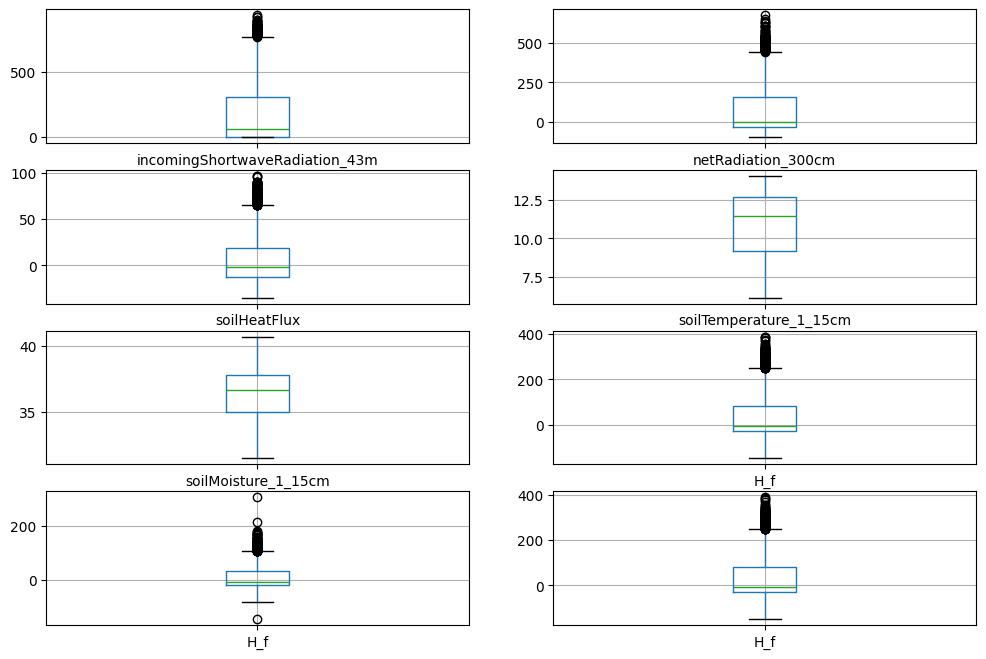

In [18]:
fig, axs = plt.subplots(4, 2, figsize=(12,8))
# check for outliers
meteo_goew.boxplot(column="incomingShortwaveRadiation_43m", ax=axs[0, 0])
meteo_fbg.boxplot(column="netRadiation_300cm", ax=axs[0, 1])
meteo_fbg.boxplot(column="soilHeatFlux", ax = axs[1, 0])
meteo_goew.boxplot(column="soilTemperature_1_15cm", ax=axs[1, 1])
meteo_goew.boxplot(column="soilMoisture_1_15cm", ax=axs[2, 0])
fluxes_goew.boxplot(column="H_f", ax=axs[2, 1])
fluxes_fbg.boxplot(column="H_f", ax=axs[3, 0])
fluxes_goew.boxplot(column="H_f", ax=axs[3, 1])




In [31]:
meteo_fbg.head()

,TIMESTAMP_START,TIMESTAMP_MID,TIMESTAMP_END,incomingShortwaveRadiation_300cm,outgoingShortwaveRadiation_300cm,netRadiation_300cm,incomingPPFD_300cm,outgoingPPFD_300cm,soilHeatFlux,airPressure,...,soilTemperature_3_30cm,soilMoisture_1_30cm,soilMoisture_2_30cm,soilMoisture_3_30cm,DATE_START,TIME_START,DATE_MID,TIME_MID,DATE_END,TIME_END
1,2024-04-01 00:00:00,2024-04-01 00:15:00,2024-04-01 00:30:00,-4.227666666666667,0.27366666666666667,-46.302667,-0.11666666666666668,-0.0029999999999999996,-10.788333,967.9609999999999,...,8.25,28.676333333333332,40.31066666666666,35.959666666666664,2024-04-01,00:00:00,2024-04-01,00:15:00,2024-04-01,00:30:00
2,2024-04-01 00:30:00,2024-04-01 00:45:00,2024-04-01 01:00:00,-3.819333333333333,0.6746666666666666,-41.648000,-0.054,-0.17666666666666667,-12.204667,967.5649999999999,...,8.24,28.670333333333332,40.34033333333334,35.952666666666666,2024-04-01,00:30:00,2024-04-01,00:45:00,2024-04-01,01:00:00
3,2024-04-01 01:00:00,2024-04-01 01:15:00,2024-04-01 01:30:00,-3.327666666666667,0.26299999999999996,-34.094333,-0.012666666666666668,-0.14766666666666664,-13.124000,967.6453333333334,...,8.24,28.661666666666665,40.329,35.96266666666667,2024-04-01,01:00:00,2024-04-01,01:15:00,2024-04-01,01:30:00
4,2024-04-01 01:30:00,2024-04-01 01:45:00,2024-04-01 02:00:00,-2.728666666666667,0.4036666666666666,-32.081667,-0.226,-0.014666666666666666,-12.753333,967.486,...,8.223333333333333,28.67233333333333,40.33733333333333,35.95466666666667,2024-04-01,01:30:00,2024-04-01,01:45:00,2024-04-01,02:00:00
5,2024-04-01 02:00:00,2024-04-01 02:15:00,2024-04-01 02:30:00,-3.356,0.309,-39.608667,-0.10866666666666669,-0.05833333333333333,-12.193333,966.9563333333334,...,8.209999999999999,28.662333333333333,40.31433333333334,35.967000000000006,2024-04-01,02:00:00,2024-04-01,02:15:00,2024-04-01,02:30:00


In [32]:
fluxes_fbg.head()

,TIMESTAMP_START,TIMESTAMP_MID,TIMESTAMP_END,H_orig,H_f,LE_orig,LE_f,ET_orig,ET_f,CO2,...,NEE_f,Reco,GPP_f,Ustar,DATE_START,TIME_START,DATE_MID,TIME_MID,DATE_END,TIME_END
1,2024-04-01 00:00:00,2024-04-01 00:15:00,2024-04-01 00:30:00,NaN,-20.988,NaN,11.719795,NaN,0.008511508839420822,NaN,...,3.666660,3.50719,-0.15947,0.09728099999999999,2024-04-01,00:00:00,2024-04-01,00:15:00,2024-04-01,00:30:00
2,2024-04-01 00:30:00,2024-04-01 00:45:00,2024-04-01 01:00:00,NaN,-22.289,NaN,11.579860,NaN,0.008407296593537516,NaN,...,3.560341,3.46063,-0.099716,0.077225,2024-04-01,00:30:00,2024-04-01,00:45:00,2024-04-01,01:00:00
3,2024-04-01 01:00:00,2024-04-01 01:15:00,2024-04-01 01:30:00,NaN,-22.491,NaN,11.606457,NaN,0.008424052965131875,NaN,...,3.555969,3.41476,-0.1412,0.055387,2024-04-01,01:00:00,2024-04-01,01:15:00,2024-04-01,01:30:00
4,2024-04-01 01:30:00,2024-04-01 01:45:00,2024-04-01 02:00:00,NaN,-22.597,NaN,11.684342,NaN,0.008478784783297867,NaN,...,3.562575,3.38323,-0.17934,0.06940299999999999,2024-04-01,01:30:00,2024-04-01,01:45:00,2024-04-01,02:00:00
5,2024-04-01 02:00:00,2024-04-01 02:15:00,2024-04-01 02:30:00,NaN,-22.597,NaN,11.684342,NaN,0.008479441751743349,NaN,...,3.562575,3.3970599999999997,-0.16551,0.071973,2024-04-01,02:00:00,2024-04-01,02:15:00,2024-04-01,02:30:00


In [34]:
# get diurnal cylces
def diurnal_cycles_goew(df_fluxes, df_meteo):
    # calculate net radiation
    df_meteo["Q"] = df_meteo["incomingShortwaveRadiation_43m"] + df_meteo["outgoingShortwaveRadiation_43m"]    
    df_fluxes_agg = df_fluxes.groupby("TIME_START").agg(H=("H_f", "mean"), LE=("LE_f", "mean"))
    df_meteo_agg = df_meteo.groupby("TIME_START").agg(Q=("Q", "mean"))
    df_joined = df_fluxes_agg.merge(df_meteo_agg, on="TIME_START")
    df_joined["H+LE"] = df_joined["H"] + df_joined["LE"] 
    return df_joined


def diurnal_cycles_fbg(df_fluxes, df_meteo):
    df_fluxes_agg = df_fluxes.groupby("TIME_START").agg(H=("H_f", "mean"), LE=("LE_f", "mean"))
    df_meteo["Q"] = df_meteo["netRadiation_300cm"].astype(float)
    df_meteo["G"] = df_meteo["soilHeatFlux"].astype(float)
    df_meteo_agg = df_meteo.groupby("TIME_START").agg(Q=("Q", "mean"), G=("G", "mean"))
    df_joined = df_fluxes_agg.merge(df_meteo_agg, on="TIME_START")
    df_joined["H+G+LE"] = df_joined["H"] + df_joined["G"] + df_joined["LE"] 
    df_joined["res"] = df_joined["Q"] - df_joined["H+G+LE"]
    return df_joined



df_goew = diurnal_cycles_goew(fluxes_goew, meteo_goew)
df_fbg = diurnal_cycles_fbg(fluxes_fbg, meteo_fbg)

<Axes: xlabel='TIME_START'>

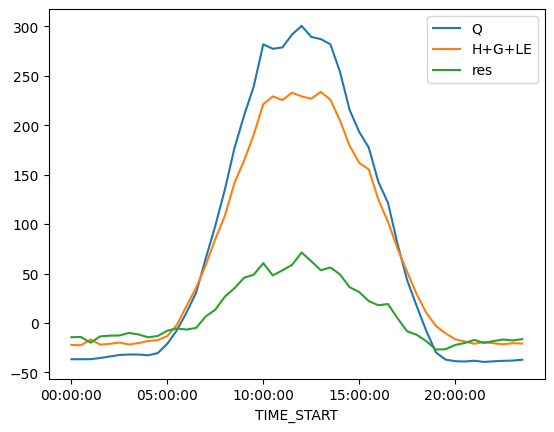

In [35]:
df_fbg[["Q", "H+G+LE", "res"]].plot()

<Axes: xlabel='TIME_START'>

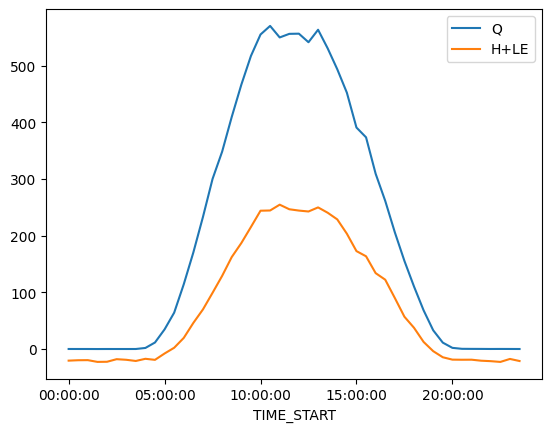

In [36]:
df_goew[["Q", "H+LE"]].plot()